<a href="https://colab.research.google.com/github/GiocomoLab/tutorials/blob/main/lmm/LMM_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixed Models Python Tutorial
### Alex Gonzalez
### 2022/9/9

## Topics

1. Linear Models
2. Statistical Testing on LM
3. Linear Mixed Models
4. Statistical Testing on LMM

## References:
https://www-sciencedirect-com.stanford.idm.oclc.org/science/article/pii/S089662732100845X#app2

https://link.springer.com/content/pdf/10.1007/978-3-662-63882-8.pdf

## Data:
https://www.ics.uci.edu/~zhaoxia/Data/BeyondTandANOVA/



### If you havent used colab before, you can mount a google drive.

1. through left UI folder selection
2. through the following command.

```
from google.colab import drive
drive.mount('/content/drive')
```


## Linear model:  $y =  x \beta  + ϵ$
1. independent variable: 

  $x → N × P \ \text{matrix}$

  design matrix, exogeneous, predictors, etc.

2. dependent variable: 

  $y → N × 1 \ \text{vector}$

  usually a measurment, endogeneous variable, 
  
3. betas: 

  $\beta → P \times 1 \ \text{vector}$

  linear parameters, mapping from $x$ to $y$

4. $ϵ → N \times 1 \ \text{random vector}$  

  error term, each entry usually assumed to be  i.i.d. $\mathcal{N} (0, σ^2)$



These are well known models from which t-tests, anovas and multiple other tests could be derived from. Let's see some examples.

## Python Imports

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# mount local drive (optional)
if 0:
  from google.colab import drive
  drive.mount('/content/drive')

### Get first data sets from the reference paper

In [3]:
# read from source links
data1 = pd.read_csv("https://www.ics.uci.edu/~zhaoxia/Data/BeyondTandANOVA/Example1.txt")
data3 = pd.read_csv("https://www.ics.uci.edu/~zhaoxia/Data/BeyondTandANOVA/Example3.txt")

In [4]:
# save to mounte drive (optional)
if 0:
  data1.to_csv(Path("/content/drive/My Drive/Teaching/Tutorials/lmm_example1.txt"))
  data3.to_csv(Path("/content/drive/My Drive/Teaching/Tutorials/lmm_example3.txt"))

In [5]:
data1.head()

,res,treatment_idx,midx
0,1.632684,1,1
1,0.969839,1,1
2,0.518493,1,1
3,0.303127,1,1
4,0.581527,1,1


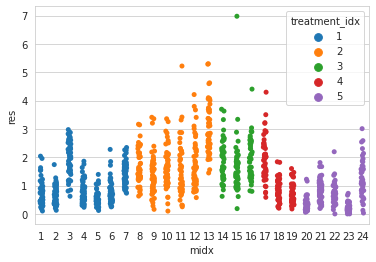

In [6]:
sns.stripplot(x='midx', y='res', hue='treatment_idx', data=data1)

## Linear model fit and traditional tests

In here we want to replicate the results of table 2 of the neuron paper. In the table they get a p value for each day. The model in this case would look like:


  $y_{i,j} = \beta_0 + \beta_1 x_{i,0} + ... + \beta_4 x_{i,4} + ϵ_i$

Where $i$ is the nueron idx, and $j$ correspond to the day/ treatment_idx. 

In matrix form:

$Y = X β$

Consequenty, the estimated function is:

$\hat{y}_{i,j} = \hat{\beta}_0 + \hat{\beta}_1 x_{i,0} + ... + \hat{\beta}_4 x_{i,4}$


Which can be used as the estimator $\hat{E}(y|x_1, ..., x_k)$.

----------------------

For this model we will use the statsmodels package framework. 

https://www.statsmodels.org/stable/index.html

smf.ols refers to ordinary least squares regression, note the formula notation. if using sm.OLS you would be directly feeding in the X and Y. 

In [7]:
m = smf.ols('res ~ 1 + treatment_idx', data=data1).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    res   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     44.37
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           4.14e-11
Time:                        18:41:45   Log-Likelihood:                -1526.9
No. Observations:                1200   AIC:                             3058.
Df Residuals:                    1198   BIC:                             3068.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5631      0.051     30.779      0.000       1.463       1.663
treatment_idx    -0.1099      0.016     -6.661      0.000      -0.142      -0.078
==============================================================================
Omnibus:                      287.794   Durbin-Watson:                   0.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              719.636
Skew:                           1.268   Prob(JB):                    5.41e-157
Kurtosis:                       5.822   Cond. No.                         6.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

what went wrong? why didn't we get an estimate for each day? we got 2 estimates, one for intercept and one for treatment_idx.

Reason 1. Treatment idx is a continous variable, not categorical. As such, it is being fit as slope such that across days the response variable will vary as a function of the value of the treatment_idx (0-4). 

Reason 2. It is one predictor, but when we formulated the model there were 5 predictors. 

Let's re-fit by first changing how treatment_idx is parsed (see the patsy package for more details).

https://patsy.readthedocs.io/en/latest/overview.html


In [8]:
m = smf.ols('res ~ 1 + C(treatment_idx)', data=data1).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    res   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           1.17e-78
Time:                        18:41:46   Log-Likelihood:                -1363.4
No. Observations:                1200   AIC:                             2737.
Df Residuals:                    1195   BIC:                             2762.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.0262      0.040     25.672      0.000       0.948       1.105
C(treatment_idx)[T.2]     0.7829      0.059     13.340      0.000       0.668       0.898
C(treatment_idx)[T.3]     0.8135      0.076     10.774      0.000       0.665       0.962
C(treatment_idx)[T.4]     0.1606      0.073      2.185      0.029       0.016       0.305
C(treatment_idx)[T.5]    -0.3605      0.063     -5.753      0.000      -0.483      -0.238
==============================================================================
Omnibus:                      297.522   Durbin-Watson:                   1.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              812.801
Skew:                           1.272   Prob(JB):                    3.18e-177
Kurtosis:                       6.128   Cond. No.                         5.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
print(m.params)
print(m.pvalues)

Intercept                1.026191
C(treatment_idx)[T.2]    0.782856
C(treatment_idx)[T.3]    0.813529
C(treatment_idx)[T.4]    0.160579
C(treatment_idx)[T.5]   -0.360473
dtype: float64
Intercept                4.064778e-116
C(treatment_idx)[T.2]     6.040147e-38
C(treatment_idx)[T.3]     6.760583e-26
C(treatment_idx)[T.4]     2.907634e-02
C(treatment_idx)[T.5]     1.112796e-08
dtype: float64


Note how the overall fit is much improved by changing how the model used the treatment_idx variable. All the model fits now match what was on the paper. But, what is each parameter and corresponding p value telling us?

In [10]:
base = data1.loc[data1.treatment_idx==1, 'res']
print(base.mean(), stats.ttest_1samp(base, 0))
for ii in np.arange(2,6):
  test_dat = data1.loc[data1.treatment_idx==ii, 'res']
  print(test_dat.mean()-base.mean(), stats.ttest_ind(test_dat, base))

1.0261907442577032 Ttest_1sampResult(statistic=29.740899200645238, pvalue=1.5683104289809018e-98)
0.7828563628620377 Ttest_indResult(statistic=12.572322153552877, pvalue=1.1410135390093402e-32)
0.813528703224311 Ttest_indResult(statistic=11.564780347735724, pvalue=1.5334558892868301e-27)
0.16057902307563032 Ttest_indResult(statistic=2.38642072947878, pvalue=0.01738056043601394)
-0.36047316621688674 Ttest_indResult(statistic=-7.126043819899659, pvalue=2.9745769579600704e-12)


So, after fitting a model with OLS, we obtain coefficients that are the mean of the control group (treatment_idx==1) with the rest being the difference between another treatment and the control. The corresponding p-values are equivalent to a two-sample ttest between the test group and the control group, with the difference in actual values between the ttest and the model coming from the estimation of variance. 

What if I don't want the difference in means as my parameters estimates, or if the control group is not the first?

In [11]:
m = smf.ols('res ~ -1 + C(treatment_idx)', data=data1).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    res   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           1.17e-78
Time:                        18:41:46   Log-Likelihood:                -1363.4
No. Observations:                1200   AIC:                             2737.
Df Residuals:                    1195   BIC:                             2762.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(treatment_idx)[1]     1.0262      0.040     25.672      0.000       0.948       1.105
C(treatment_idx)[2]     1.8090      0.043     42.105      0.000       1.725       1.893
C(treatment_idx)[3]     1.8397      0.064     28.719      0.000       1.714       1.965
C(treatment_idx)[4]     1.1868      0.062     19.245      0.000       1.066       1.308
C(treatment_idx)[5]     0.6657      0.048     13.797      0.000       0.571       0.760
==============================================================================
Omnibus:                      297.522   Durbin-Watson:                   1.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              812.801
Skew:                           1.272   Prob(JB):                    3.18e-177
Kurtosis:                       6.128   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
base = data1.loc[data1.treatment_idx==1, 'res']
print(base.mean(), stats.ttest_1samp(base, 0))
for ii in np.arange(2,6):
  test_dat = data1.loc[data1.treatment_idx==ii, 'res']
  print(test_dat.mean(), stats.ttest_1samp(test_dat, 0))

1.0261907442577032 Ttest_1sampResult(statistic=29.740899200645238, pvalue=1.5683104289809018e-98)
1.809047107119741 Ttest_1sampResult(statistic=33.64638258254568, pvalue=3.5851002369498526e-105)
1.8397194474820142 Ttest_1sampResult(statistic=26.384861112272816, pvalue=9.021732722432135e-56)
1.1867697673333335 Ttest_1sampResult(statistic=18.681525052179126, pvalue=7.070208017507223e-41)
0.6657175780408164 Ttest_1sampResult(statistic=19.21455117830409, pvalue=9.794830499705795e-51)


In this case, the parameters estimates are just the means for each group as that is the least squares solution. The equivalent test is a simple 1 sample ttest of the parameter against zero.

There's no fundamental difference between the two versions of the model as the variables are linearly dependent. However, the parameters that you get, and the p-values are fundamentally different.

For completeness, let's fit the above a third time, but changing how treatment_idx is coded.

In [13]:
data1c = data1.copy()
for ii in range(1,6):
  if ii==1:
    var = 'c'
  else:
    var = f't_{ii}'
  data1c[var] = 0
  data1c.loc[data1c.treatment_idx==ii, var] = 1

data1c

,res,treatment_idx,midx,c,t_2,t_3,t_4,t_5
0,1.632684,1,1,1,0,0,0,0
1,0.969839,1,1,1,0,0,0,0
2,0.518493,1,1,1,0,0,0,0
3,0.303127,1,1,1,0,0,0,0
4,0.581527,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1195,1.533250,5,24,0,0,0,0,1
1196,0.533854,5,24,0,0,0,0,1
1197,1.580074,5,24,0,0,0,0,1
1198,2.586787,5,24,0,0,0,0,1


In [14]:
m = smf.ols('res ~ -1 + c + t_2 + t_3 + t_4 + t_5', data=data1c).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    res   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           1.17e-78
Time:                        18:41:46   Log-Likelihood:                -1363.4
No. Observations:                1200   AIC:                             2737.
Df Residuals:                    1195   BIC:                             2762.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c              1.0262      0.040     25.672      0.000       0.948       1.105
t_2            1.8090      0.043     42.105      0.000       1.725       1.893
t_3            1.8397      0.064     28.719      0.000       1.714       1.965
t_4            1.1868      0.062     19.245      0.000       1.066       1.308
t_5            0.6657      0.048     13.797      0.000       0.571       0.760
==============================================================================
Omnibus:                      297.522   Durbin-Watson:                   1.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              812.801
Skew:                           1.272   Prob(JB):                    3.18e-177
Kurtosis:                       6.128   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

a completely equivalent result as above. Note that if we try to add back the intercept term, the fitting will either fail or produce incorrect values.

In [15]:
m = smf.ols('res ~ 1 + c + t_2 + t_3 + t_4 + t_5', data=data1c).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    res   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     106.3
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           1.53e-77
Time:                        18:41:46   Log-Likelihood:                -1366.0
No. Observations:                1200   AIC:                             2742.
Df Residuals:                    1195   BIC:                             2767.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1.64e+12   7.91e+12     -0.207      0.836   -1.72e+13    1.39e+13
c            1.64e+12   7.91e+12      0.207      0.836   -1.39e+13    1.72e+13
t_2          1.64e+12   7.91e+12      0.207      0.836   -1.39e+13    1.72e+13
t_3          1.64e+12   7.91e+12      0.207      0.836   -1.39e+13    1.72e+13
t_4          1.64e+12   7.91e+12      0.207      0.836   -1.39e+13    1.72e+13
t_5          1.64e+12   7.91e+12      0.207      0.836   -1.39e+13    1.72e+13
==============================================================================
Omnibus:                      304.125   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              839.912
Skew:                           1.296   Prob(JB):                    4.12e-183
Kurtosis:                       6.175   Cond. No.                     9.84e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.52e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Let's do a bit of hypothesis testing. There are a number of ways to do this, including wald tests, post-hoc ttests, or likelihood ratio tests. I will cover wald tests here, and likelihood ratio tests when we get to LMM.

In [16]:
m = smf.ols('res ~ 1 + C(treatment_idx)', data=data1).fit()
m.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    res   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           1.17e-78
Time:                        18:41:46   Log-Likelihood:                -1363.4
No. Observations:                1200   AIC:                             2737.
Df Residuals:                    1195   BIC:                             2762.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.0262      0.040     25.672      0.000       0.948       1.105
C(treatment_idx)[T.2]     0.7829      0.059     13.340      0.000       0.668       0.898
C(treatment_idx)[T.3]     0.8135      0.076     10.774      0.000       0.665       0.962
C(treatment_idx)[T.4]     0.1606      0.073      2.185      0.029       0.016       0.305
C(treatment_idx)[T.5]    -0.3605      0.063     -5.753      0.000      -0.483      -0.238
==============================================================================
Omnibus:                      297.522   Durbin-Watson:                   1.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              812.801
Skew:                           1.272   Prob(JB):                    3.18e-177
Kurtosis:                       6.128   Cond. No.                         5.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

let's test the joint hypothesis that the treatments elicit a different response than the control.

In [17]:
print(m.wald_test_terms())

                           F            P>F  df constraint  df denom
Intercept         659.070235  4.064778e-116              1    1195.0
C(treatment_idx)  108.089431   1.173920e-78              4    1195.0


or, equivalently, this is the one-way ANOVA.

In [18]:
print(sm.stats.anova_lm(m))

                      df      sum_sq    mean_sq           F        PR(>F)
C(treatment_idx)     4.0  246.624334  61.656084  108.089431  1.173920e-78
Residual          1195.0  681.648698   0.570417         NaN           NaN


if each term is fitted independently, you need to construct the joint hypothesis matrix.

In [19]:
m = smf.ols('res ~ -1 + c + t_2 + t_3 + t_4 + t_5', data=data1c).fit()
print(m.wald_test_terms())

               F            P>F  df constraint  df denom
c     659.070235  4.064778e-116              1    1195.0
t_2  1772.823611  2.632537e-238              1    1195.0
t_3   824.755641  2.335611e-138              1    1195.0
t_4   370.366335   4.161638e-72              1    1195.0
t_5   190.350240   2.737735e-40              1    1195.0


In [20]:
A = np.eye(5)
A[:,0]=-1
A = A[1:,:]
print(A)
print(m.wald_test(A))

[[-1.  1.  0.  0.  0.]
 [-1.  0.  1.  0.  0.]
 [-1.  0.  0.  1.  0.]
 [-1.  0.  0.  0.  1.]]
<F test: F=array([[108.08943106]]), p=1.1739200802091384e-78, df_denom=1.2e+03, df_num=4>


## Linear Mixed Models

A random intercept model can be expressed as:

$Y = X β + Zu + ϵ$

Where $Y,X,\beta$ are as in the linear model case, and the new terms are:

Clustering/grouping variable.
$Z → N \times Q \ \text{matrix}$

where $Q$ are the number of groups, and

$u \rightarrow Q \times 1 \ \text{vector}$ 

of random variables $\mathcal{N}(0, Σ_{q})$.

Another way to describe the above is:

$y_i \sim \mathcal{N}(X_i\beta, \sigma^2 I_{q}+ τ^2_q J_{q})$

Where $J$ is a qxq matrix of ones, and $\tau$ represents the within subject variance. Note that within subject correlation is constant from measurement to measurement. 

First, let's fill out the rest of table 2 by a LME on the pCreb data.

we will be using the formula approach with the function 

``` 
smf.mixedlm 
```

Note that to specify a clustering (grouping/subjects) variable you need to specify it as groups, `groups='midx'`. It will naturally infer that this is a categorical variable.

Also, on the fitting stage we used `reml=True`, which tells statsmodels to fit using restricted maximum likelihood. The why is a longer topic, but basically subject level estimates of variance are biased otherwise. By using REML, the likelihood model thats fitted is correctly specified for the variance components and the estimates are unbiased. 

In [21]:
m = smf.mixedlm('res ~ 1 + C(treatment_idx)', groups='midx', data=data1).fit(reml=True)
m.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   res       
No. Observations:     1200      Method:               REML      
No. Groups:           24        Scale:                0.3594    
Min. group size:      42        Log-Likelihood:       -1132.2330
Max. group size:      57        Converged:            Yes       
Mean group size:      50.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.001    0.196  5.096 0.000  0.616  1.386
C(treatment_idx)[T.2]  0.819    0.289  2.835 0.005  0.253  1.386
C(treatment_idx)[T.3]  0.843    0.359  2.349 0.019  0.140  1.546
C(treatment_idx)[T.4]  0.190    0.359  0.529 0.597 -0.513  0.893
C(treatment_idx)[T.5] -0.320    0.304 -1.051 0.293 -0.916  0.276
midx Var               0.263    0.147                           
================================================================

"""

In [22]:
print(m.params)
print(m.pvalues)

print(m.wald_test_terms())

Intercept                1.000673
C(treatment_idx)[T.2]    0.819449
C(treatment_idx)[T.3]    0.842947
C(treatment_idx)[T.4]    0.189843
C(treatment_idx)[T.5]   -0.319988
midx Var                 0.731319
dtype: float64
Intercept                3.475148e-07
C(treatment_idx)[T.2]    4.580955e-03
C(treatment_idx)[T.3]    1.882390e-02
C(treatment_idx)[T.4]    5.965338e-01
C(treatment_idx)[T.5]    2.930608e-01
midx Var                 2.914396e-03
dtype: float64
                       chi2        P>chi2  df constraint
Intercept         25.965826  3.475148e-07              1
C(treatment_idx)  18.751395  8.794348e-04              4


Note that the p-values are slightly different than in the paper, and that's a difference between the R packages and statsmodels (I believe statsmodels uses the z=coef/std, and then compares to a normal distrubution while R compares to a t distribution. The df are a bit messy on LME models, and for accurate df you need some additional calculations/tools.

-----------------
***Note the reml=False***. Why? In order to correctly do nested likelihood comparison (LRT; likelihood ratio test), The models need to be fitted using Maximum likelihood, not the REML. Again, longer topic, and I would need to study more to be able to explain it correctly :). 

-------------
***LRT***


Suppose you have a model with a set of $Θ$ parameters, and you want to test that inclusion of $\theta \in \Theta$ leads to a better fit of the data than without it. In such a case, you need to fit a mode excluding $\theta$, which we call the null/simple model $\Theta_0$. With those two fits, we can then find the likelihoods for each model and compute the likelihood ratio:

$\lambda_{LR} = 2 (l(\Theta) - l(\Theta_0)) $

It turns out that $\lambda_{LR} \sim \mathcal{X}(p)$, that is, $\lambda_{LR}$ is chi squared distrubtued with p being the difference in number of parameters between the models. This can be used to get a significance score, though the metric itself is quite intuitive (eg. \lambda_{LR} =2, the full model is twice as likely as the null). 

Likelihood ratio tests:
https://en.wikipedia.org/wiki/Likelihood-ratio_test


-------------
Now, let's do a likelihood ratio test to find the significance of the treatment. 


In [23]:
m_full = smf.mixedlm('res ~ 1 + C(treatment_idx)', groups='midx', data=data1).fit(reml=False)
m_null = smf.mixedlm('res ~ 1', groups='midx', data=data1).fit(reml=False)

LRT = 2*(m_full.llf-m_null.llf)
pval = stats.chi2.sf(LRT,4)
print(f"LRT = {LRT:0.2f}; pval={pval:1.2e}")

LRT = 16.48; pval=2.44e-03


The above are the same as in R. 

Let's examine those random effects.

In [24]:
m = smf.mixedlm('res ~ 1 + C(treatment_idx)', groups='midx', data=data1).fit(reml=True)
print(m.summary())
print(m.random_effects)

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   res       
No. Observations:     1200      Method:               REML      
No. Groups:           24        Scale:                0.3594    
Min. group size:      42        Log-Likelihood:       -1132.2330
Max. group size:      57        Converged:            Yes       
Mean group size:      50.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.001    0.196  5.096 0.000  0.616  1.386
C(treatment_idx)[T.2]  0.819    0.289  2.835 0.005  0.253  1.386
C(treatment_idx)[T.3]  0.843    0.359  2.349 0.019  0.140  1.546
C(treatment_idx)[T.4]  0.190    0.359  0.529 0.597 -0.513  0.893
C(treatment_idx)[T.5] -0.320    0.304 -1.051 0.293 -0.916  0.276
midx Var               0.263    0.147  

In [25]:
for ii in np.arange(1,8):
  print(data1.loc[data1.midx==ii, 'res'].mean()-m.params[0])
print()
for ii in np.arange(8,14):
  print(data1.loc[data1.midx==ii, 'res'].mean()-m.params[0]-m.params[1])

-0.26540038124646403
-0.36741137158146586
0.9806800950001666
-0.19258274579653645
-0.46881446594703824
-0.16638963740864776
0.47520805313508707

-0.19507099288153307
-0.4439415396764046
-0.2015605767134414
-0.25903641272605005
-0.05320243841854255
1.1545550079426425


similar to other parameters, the randome effects (intercepts) are simply the group means (note the difference between the first for loop and the second in estimating the means)

### A nested example:
For this one, we will load example 3 from the data in the paper. 

In [26]:
data3 = pd.read_csv("https://www.ics.uci.edu/~zhaoxia/Data/BeyondTandANOVA/Example3.txt")
data3 = data3.dropna()
data3.head()

,res,treatment,midx,cidx
0,6.336914,1,5,1
1,6.306270,1,5,2
2,6.303228,1,5,3
3,6.293195,1,2,4
4,6.281103,1,5,5


let's first fit the linear model

In [27]:
%%time
m = smf.ols('res ~ treatment', data=data3).fit()
print(m.summary())
print(m.wald_test_terms())


                            OLS Regression Results                            
Dep. Variable:                    res   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.492
Date:                Fri, 09 Sep 2022   Prob (F-statistic):            0.00360
Time:                        18:41:49   Log-Likelihood:                -4863.1
No. Observations:                2489   AIC:                             9730.
Df Residuals:                    2487   BIC:                             9742.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7321      0.108     25.258      0.0

Now lets do the mixed model with the grouping variable for mouse, note that we are not including cell idx in this one.

In [28]:
m = smf.mixedlm('res ~ treatment', groups='midx', data=data3).fit()
print(m.summary())
print(m.wald_test_terms())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: res       
No. Observations: 2489    Method:             REML      
No. Groups:       11      Scale:              2.7562    
Min. group size:  76      Log-Likelihood:     -4810.2578
Max. group size:  492     Converged:          No        
Mean group size:  226.3                                 
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  2.796     0.169  16.564  0.000   2.465   3.127
treatment  0.198     0.067   2.973  0.003   0.067   0.328
midx Var   0.189     0.055                               

                 chi2        P>chi2  df constraint
Intercept  274.349820  1.279123e-61              1
treatment    8.840212  2.946649e-03              1


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.179060
  warnings.warn(msg, ConvergenceWarning)


now to add the additional by cell part:

In [29]:
vc = {'cells':'0+C(cidx)'}
m = smf.mixedlm('res ~ treatment', groups='midx',re_formula='1', vc_formula=vc, data=data3).fit()
print(m.summary())
print(m.wald_test_terms())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: res       
No. Observations: 2489    Method:             REML      
No. Groups:       11      Scale:              1.5883    
Min. group size:  76      Log-Likelihood:     -4687.4155
Max. group size:  492     Converged:          Yes       
Mean group size:  226.3                                 
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  2.799     0.156  17.974  0.000   2.494   3.104
treatment  0.193     0.051   3.827  0.000   0.094   0.293
midx Var   0.182     0.073                               
cells Var  1.173     0.089                               

                 chi2        P>chi2  df constraint
Intercept  323.076018  3.096618e-72              1
treatment   14.646587  1.296692e-04              1


In [30]:
print(m.params)
print(m.pvalues)

Intercept    2.799080
treatment    0.193472
midx Var     0.114764
cells Var    0.738625
dtype: float64
Intercept    3.096618e-72
treatment    1.296692e-04
midx Var     4.648923e-02
cells Var    1.150218e-25
dtype: float64


In [31]:
m.random_effects[1]

midx                   -0.486156
cells[C(cidx)[46]]      1.503783
cells[C(cidx)[74]]      1.380281
cells[C(cidx)[86]]      0.709829
cells[C(cidx)[98]]      2.514744
                          ...   
cells[C(cidx)[1240]]   -1.361284
cells[C(cidx)[1242]]   -1.339454
cells[C(cidx)[1246]]   -1.523111
cells[C(cidx)[1247]]   -1.552317
cells[C(cidx)[1248]]   -1.552317
Length: 249, dtype: float64

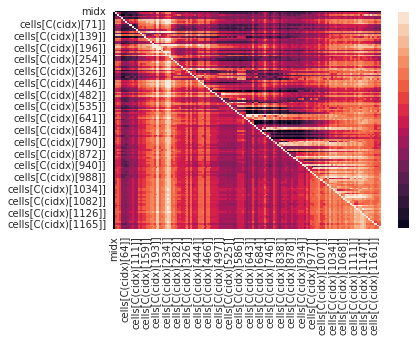

In [32]:
sns.heatmap(m.random_effects_cov[2], robust=True)

random slope model

In [33]:
vc = {'cells':'0+C(cidx)'}
m = smf.mixedlm('res ~ treatment', groups='midx',re_formula='~1+treatment', vc_formula=vc, data=data3).fit()
print(m.summary())
print(m.wald_test_terms())



             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   res       
No. Observations:    2489      Method:               REML      
No. Groups:          11        Scale:                1.5778    
Min. group size:     76        Log-Likelihood:       -4685.7672
Max. group size:     492       Converged:            Yes       
Mean group size:     226.3                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.825    0.199 14.210 0.000  2.435  3.214
treatment             0.178    0.071  2.491 0.013  0.038  0.317
midx Var              0.342    0.158                           
midx x treatment Cov -0.072    0.051                           
treatment Var         0.025    0.020                           
cells Var             1.178    0.089                 

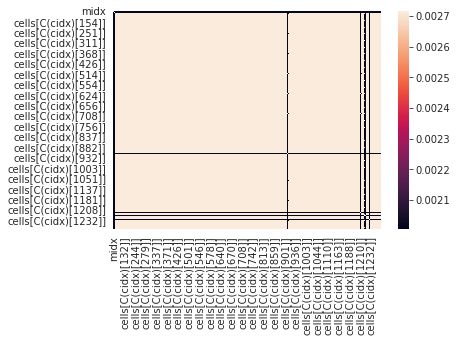

In [34]:
sns.heatmap(m.random_effects_cov[1], robust=True)